# Business Problem:
One of the global banks would like to understand what factors driving credit card spend are. The bank want use these insights to calculate credit limit. In order to solve the problem, the bank conducted survey of 5000 customers and collected data.

The objective of this case study is to understand what’s driving the total spend (Primary Card + Secondary card). Given the factors, predict credit limit for the new applicants.

# Machine learning work steps through python

In [5]:
# Import important libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels as sm
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

In [7]:
#Data importing
credit_card = pd.read_excel(r"C:\Users\ABHISHEK RAJ\Desktop\Skillcept\Projects\Project 1\Data Set.xlsx")
credit_card.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,...,1,0,0,0,0,0,1,0,0,0
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,...,1,0,1,1,1,0,1,1,0,0
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,...,1,0,1,0,1,0,0,0,1,0


In [12]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to response_03
dtypes: float64(31), int64(97), object(2)
memory usage: 5.0+ MB


# Data Cleaning

In [13]:
credit_card.columns

Index(['custid', 'region', 'townsize', 'gender', 'age', 'agecat', 'birthmonth',
       'ed', 'edcat', 'jobcat',
       ...
       'owncd', 'ownpda', 'ownpc', 'ownipod', 'owngame', 'ownfax', 'news',
       'response_01', 'response_02', 'response_03'],
      dtype='object', length=130)

In [14]:
# Creating dependent Y Column
#To create Y we need to sumup cardspent(first card spent amount) and card2spent(Second card spent amount)
credit_card['totalspend'] = credit_card['cardspent'] + credit_card['card2spent']
credit_card.drop(columns=['cardspent','card2spent'],inplace=True) #Drop 2 repeated column because we already taken their sum

In [15]:
# Dropping irrelavant columns 
credit_card.drop(columns=['custid','birthmonth'],inplace=True)
# Dropped 2 columns

In [16]:
credit_card.columns

Index(['region', 'townsize', 'gender', 'age', 'agecat', 'ed', 'edcat',
       'jobcat', 'union', 'employ',
       ...
       'ownpda', 'ownpc', 'ownipod', 'owngame', 'ownfax', 'news',
       'response_01', 'response_02', 'response_03', 'totalspend'],
      dtype='object', length=127)

In [17]:
#Defining categorical values
for x in ['gender','jobcat', 'union','retire','default','marital','homeown','hometype','carown','cartype','carcatvalue','carbought','carbuy',
                 'commutecat','reason','polview','card','cardtype','cardbenefit','cardfee','cardtenurecat','card2','card2type','card2benefit','card2fee',
                 'card2tenurecat','bfast','internet']:
    credit_card[x] = credit_card[x].astype('object')

In [18]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 127 entries, region to totalspend
dtypes: float64(30), int64(69), object(28)
memory usage: 4.8+ MB


As object type data was in integer, Now all are changed  into their original form.

# separation of continuous variables and categorical variables

In [19]:
conti_vars=credit_card.select_dtypes(['float64','int64'])
cat_vars=credit_card.select_dtypes('object')
conti_vars.head()

,region,townsize,age,agecat,ed,edcat,employ,empcat,income,lninc,inccat,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,jobsat,spoused,spousedcat,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,address,addresscat,cars,carvalue,commute,commutetime,commutecar,commutemotorcycle,commutecarpool,commutebus,commuterail,commutepublic,commutebike,commutewalk,commutenonmotor,telecommute,polparty,polcontrib,vote,cardtenure,card2tenure,active,tenure,churn,longmon,lnlongmon,longten,lnlongten,tollfree,tollmon,lntollmon,tollten,lntollten,equip,equipmon,lnequipmon,equipten,lnequipten,callcard,cardmon,lncardmon,cardten,lncardten,wireless,wiremon,lnwiremon,wireten,lnwireten,multline,voice,pager,callid,callwait,forward,confer,ebill,owntv,hourstv,ownvcr,owndvd,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,totalspend
0,1,2.0,20,2,15,3,0,1,31,3.433987,2,11.1,1.200909,0.183079,2.240091,0.806516,1,-1,-1,3,0,0,0,0,0,0,0,0,0,1,2,14.3,8,22.0,0,1,1,0,0,0,0,1,0,0,1,0,1,2,3,0,5,1,6.50,1.871802,34.40,3.538057,1,29.0,3.367296,161.05,5.081715,1,29.50,3.384390,126.1,4.837075,1,14.25,2.656757,60.0,4.094345,0,0.00,NaN,0.00,NaN,1,1,1,0,1,1,1,0,1,13,1,1,0,0,0,1,1,0,0,0,1,0,149.46
1,5,5.0,22,2,17,4,0,1,15,2.708050,1,18.6,1.222020,0.200505,1.567980,0.449788,1,-1,-1,2,6,0,0,0,0,0,0,6,2,1,2,6.8,1,29.0,1,0,0,1,0,0,1,0,1,1,1,0,0,4,4,1,39,0,8.90,2.186051,330.60,5.800909,0,0.0,NaN,0.00,NaN,1,54.85,4.004602,1975.0,7.588324,1,16.00,2.772589,610.0,6.413459,1,45.65,3.821004,1683.55,7.428660,1,1,1,1,0,1,0,1,1,18,1,1,1,1,1,1,1,1,1,0,0,0,77.54
2,3,4.0,67,6,14,2,16,5,35,3.555348,2,9.9,0.928620,-0.074056,2.536380,0.930738,4,13,2,3,3,2,1,0,0,0,0,0,30,5,3,18.8,4,24.0,1,0,1,1,1,0,0,0,0,0,1,0,0,35,25,0,65,0,28.40,3.346389,1858.35,7.527444,0,0.0,NaN,0.00,NaN,0,0.00,NaN,0.0,NaN,1,23.00,3.135494,1410.0,7.251345,0,0.00,NaN,0.00,NaN,1,0,0,0,0,0,0,0,1,21,1,1,1,0,0,0,0,0,1,0,0,0,359.97
3,4,3.0,23,2,16,3,0,1,20,2.995732,1,5.7,0.022800,-3.780995,1.117200,0.110826,2,18,4,5,0,0,0,0,0,0,0,0,3,2,3,8.7,1,38.0,1,0,0,0,0,0,0,0,0,0,0,0,0,5,5,1,36,0,6.00,1.791759,199.45,5.295564,0,0.0,NaN,0.00,NaN,0,0.00,NaN,0.0,NaN,1,21.00,3.044522,685.0,6.529419,0,0.00,NaN,0.00,NaN,1,0,0,0,0,0,0,1,1,26,1,1,1,0,1,1,1,0,1,1,0,0,359.41
4,2,2.0,26,3,16,3,1,1,23,3.135494,1,1.7,0.214659,-1.538705,0.176341,-1.735336,1,13,2,4,0,0,0,0,0,0,0,0,3,2,1,10.6,6,32.0,0,0,0,0,0,1,0,1,0,0,0,0,0,8,9,1,21,0,3.05,1.115142,74.10,4.305416,1,16.5,2.803360,387.70,5.960232,0,0.00,NaN,0.0,NaN,1,17.25,2.847812,360.0,5.886104,1,19.05,2.947067,410.80,6.018106,0,1,0,1,1,1,1,0,1,27,1,1,1,0,1,0,1,0,0,0,1,0,507.83


In [20]:
cat_vars.head()

,gender,jobcat,union,retire,default,marital,homeown,hometype,carown,cartype,carcatvalue,carbought,carbuy,commutecat,reason,polview,card,cardtype,cardbenefit,cardfee,cardtenurecat,card2,card2type,card2benefit,card2fee,card2tenurecat,bfast,internet
0,1,1,1,0,1,0,0,2,1,0,1,0,0,4,9,6,3,1,1,0,2,5,3,1,0,2,3,0
1,0,2,0,0,1,0,1,3,1,1,1,0,0,1,9,4,2,4,1,0,2,4,1,3,0,2,1,4
2,1,2,0,0,0,1,1,1,1,1,1,0,1,3,2,5,2,1,4,0,5,4,1,3,0,5,3,0
3,0,2,0,0,1,1,1,3,1,1,1,0,1,1,9,3,2,1,4,0,2,3,2,4,0,2,1,2
4,0,2,0,0,0,1,0,2,0,1,1,0,1,3,9,4,4,2,1,0,3,1,3,2,0,3,3,3


In [21]:
conti_vars.describe().T

,count,mean,std,min,25%,50%,75%,max
region,5000.0,3.001400,1.421760,1.00,2.0000,3.00,4.0000,5.00
townsize,4998.0,2.687275,1.425925,1.00,1.0000,3.00,4.0000,5.00
age,5000.0,47.025600,17.770338,18.00,31.0000,47.00,62.0000,79.00
agecat,5000.0,4.238800,1.308785,2.00,3.0000,4.00,5.0000,6.00
ed,5000.0,14.543000,3.281083,6.00,12.0000,14.00,17.0000,23.00
...,...,...,...,...,...,...,...,...
news,5000.0,0.472600,0.499299,0.00,0.0000,0.00,1.0000,1.00
response_01,5000.0,0.083600,0.276815,0.00,0.0000,0.00,0.0000,1.00
response_02,5000.0,0.129800,0.336117,0.00,0.0000,0.00,0.0000,1.00
response_03,5000.0,0.102600,0.303466,0.00,0.0000,0.00,0.0000,1.00


In [22]:
# counting missing percent from continuous variable
missper = conti_vars.isnull().sum()/conti_vars.shape[0]*100

In [23]:

missper

region         0.00
townsize       0.04
age            0.00
agecat         0.00
ed             0.00
               ... 
news           0.00
response_01    0.00
response_02    0.00
response_03    0.00
totalspend     0.00
Length: 99, dtype: float64

In [24]:
# checking such columns which have missing value more than 25%
miss_col = missper[missper>25].keys
miss_col

<bound method Series.keys of lntollmon     52.44
lntollten     52.44
lnequipmon    65.92
lnequipten    65.92
lncardmon     28.38
lncardten     28.44
lnwiremon     73.12
lnwireten     73.12
dtype: float64>

In [25]:
# Drop such columns that having missing percent more than 25%
conti_vars.drop(columns=['lntollten','lnequipmon','lnequipten','lncardmon','lncardten','lnwiremon','lnwireten'],inplace=True)

Dropped 7 features because of high missing values

In [26]:
cat_vars.describe().T

,count,unique,top,freq
gender,5000,2,1,2518
jobcat,5000,6,2,1640
union,5000,2,0,4244
retire,5000,2,0,4262
default,5000,2,0,3829
marital,5000,2,0,2599
homeown,5000,2,1,3148
hometype,5000,4,1,2265
carown,5000,3,1,3704
cartype,5000,3,0,2287


In [27]:
# counting missing percent from categorical variable
cat_vars.isnull().sum()

gender            0
jobcat            0
union             0
retire            0
default           0
marital           0
homeown           0
hometype          0
carown            0
cartype           0
carcatvalue       0
carbought         0
carbuy            0
commutecat        0
reason            0
polview           0
card              0
cardtype          0
cardbenefit       0
cardfee           0
cardtenurecat     0
card2             0
card2type         0
card2benefit      0
card2fee          0
card2tenurecat    0
bfast             0
internet          0
dtype: int64

No missing value in categorical variable

# Handling Outliers
There are some extreame high or extream low value which need to rectify so that it will not have impact on our model

In [28]:
#Handling Outliers for numerical data
conti_vars = conti_vars.apply(lambda x: x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))

In [29]:
conti_vars.describe().T

,count,mean,std,min,25%,50%,75%,max
region,5000.0,3.001400,1.421760,1.0000,2.0000,3.00,4.0000,5.0000
townsize,4998.0,2.687275,1.425925,1.0000,1.0000,3.00,4.0000,5.0000
age,5000.0,47.025600,17.770338,18.0000,31.0000,47.00,62.0000,79.0000
agecat,5000.0,4.238800,1.308785,2.0000,3.0000,4.00,5.0000,6.0000
ed,5000.0,14.544200,3.242553,8.0000,12.0000,14.00,17.0000,21.0000
...,...,...,...,...,...,...,...,...
news,5000.0,0.472600,0.499299,0.0000,0.0000,0.00,1.0000,1.0000
response_01,5000.0,0.083600,0.276815,0.0000,0.0000,0.00,0.0000,1.0000
response_02,5000.0,0.129800,0.336117,0.0000,0.0000,0.00,0.0000,1.0000
response_03,5000.0,0.102600,0.303466,0.0000,0.0000,0.00,0.0000,1.0000


# Missing value Imputation
Filling the missing values for continous variable

In [30]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(conti_vars)
conti_vars.isnull().sum()

region         0
townsize       2
age            0
agecat         0
ed             0
              ..
news           0
response_01    0
response_02    0
response_03    0
totalspend     0
Length: 92, dtype: int64

In [31]:
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x
  
conti_vars = conti_vars.apply(missing_imputation)
conti_vars.isnull().sum()

region         0
townsize       0
age            0
agecat         0
ed             0
              ..
news           0
response_01    0
response_02    0
response_03    0
totalspend     0
Length: 92, dtype: int64

# Dummy Creation

In [32]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

In [33]:
cat_vars = credit_card[['gender','jobcat', 'union','retire','default','marital','homeown','hometype','carown','cartype','carcatvalue','carbought','carbuy',
                 'commutecat','reason','polview','card','cardtype','cardbenefit','cardfee','cardtenurecat','card2','card2type','card2benefit','card2fee',
                 'card2tenurecat','bfast','internet']]

# for c_feature in categorical_features
for c_feature in ['gender','jobcat', 'union','retire','default','marital','homeown','hometype','carown','cartype','carcatvalue','carbought','carbuy',
                 'commutecat','reason','polview','card','cardtype','cardbenefit','cardfee','cardtenurecat','card2','card2type','card2benefit','card2fee',
                 'card2tenurecat','bfast','internet']:
    cat_vars[c_feature] = cat_vars[c_feature].astype('category')
    cat_vars = create_dummies(cat_vars, c_feature)
 

cat_vars.head()

,gender_1,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,union_1,retire_1,default_1,marital_1,homeown_1,hometype_2,hometype_3,hometype_4,carown_0,carown_1,cartype_0,cartype_1,carcatvalue_1,carcatvalue_2,carcatvalue_3,carbought_0,carbought_1,carbuy_1,commutecat_2,commutecat_3,commutecat_4,commutecat_5,reason_2,reason_3,reason_4,reason_9,polview_2,polview_3,polview_4,polview_5,polview_6,polview_7,card_2,card_3,card_4,card_5,cardtype_2,cardtype_3,cardtype_4,cardbenefit_2,cardbenefit_3,cardbenefit_4,cardfee_1,cardtenurecat_2,cardtenurecat_3,cardtenurecat_4,cardtenurecat_5,card2_2,card2_3,card2_4,card2_5,card2type_2,card2type_3,card2type_4,card2benefit_2,card2benefit_3,card2benefit_4,card2fee_1,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,bfast_2,bfast_3,internet_1,internet_2,internet_3,internet_4
0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
2,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
3,0,1,0,0,0,0,0,0,1,1,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0


# Final Dataset

In [34]:
# Merge the continuous and categorical variable in same data frame
credit_cards = pd.concat([conti_vars, cat_vars], axis = 1)
credit_cards.head()

,region,townsize,age,agecat,ed,edcat,employ,empcat,income,lninc,inccat,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,jobsat,spoused,spousedcat,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,address,addresscat,cars,carvalue,commute,commutetime,commutecar,commutemotorcycle,commutecarpool,commutebus,commuterail,commutepublic,commutebike,commutewalk,commutenonmotor,telecommute,polparty,polcontrib,vote,cardtenure,card2tenure,active,tenure,churn,longmon,lnlongmon,longten,lnlongten,tollfree,tollmon,lntollmon,tollten,equip,equipmon,equipten,callcard,cardmon,cardten,wireless,wiremon,wireten,multline,voice,pager,callid,callwait,forward,confer,ebill,owntv,hourstv,ownvcr,owndvd,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,totalspend,gender_1,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,union_1,retire_1,default_1,marital_1,homeown_1,hometype_2,hometype_3,hometype_4,carown_0,carown_1,cartype_0,cartype_1,carcatvalue_1,carcatvalue_2,carcatvalue_3,carbought_0,carbought_1,carbuy_1,commutecat_2,commutecat_3,commutecat_4,commutecat_5,reason_2,reason_3,reason_4,reason_9,polview_2,polview_3,polview_4,polview_5,polview_6,polview_7,card_2,card_3,card_4,card_5,cardtype_2,cardtype_3,cardtype_4,cardbenefit_2,cardbenefit_3,cardbenefit_4,cardfee_1,cardtenurecat_2,cardtenurecat_3,cardtenurecat_4,cardtenurecat_5,card2_2,card2_3,card2_4,card2_5,card2type_2,card2type_3,card2type_4,card2benefit_2,card2benefit_3,card2benefit_4,card2fee_1,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,bfast_2,bfast_3,internet_1,internet_2,internet_3,internet_4
0,1,2.0,20,2,15,3,0,1,31.0,3.433987,2,11.1,1.200909,0.183079,2.240091,0.806516,1,-1,-1,3,0,0,0,0,0,0,0,0,0,1,2,14.3,8,22.0,0,1,1,0,0,0,0,1,0,0,1,0,1,2,3,0,5,1,6.50,1.871802,34.40,3.538057,1,29.0,3.367296,161.05,1,29.50,126.1,1,14.25,60.0,0,0.00,0.00,1,1,1,0,1,1,1,0,1,13,1,1,0,0,0,1,1,0,0,0,1,0,149.46,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1,5,5.0,22,2,17,4,0,1,15.0,2.708050,1,18.6,1.222020,0.200505,1.567980,0.449788,1,-1,-1,2,6,0,0,0,0,0,0,6,2,1,2,6.8,1,29.0,1,0,0,1,0,0,1,0,1,1,1,0,0,4,4,1,39,0,8.90,2.186051,330.60,5.800909,0,0.0,3.242727,0.00,1,54.85,1975.0,1,16.00,610.0,1,45.65,1683.55,1,1,1,1,0,1,0,1,1,18,1,1,1,1,1,1,1,1,1,0,0,0,77.54,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
2,3,4.0,67,6,14,2,16,5,35.0,3.555348,2,9.9,0.928620,-0.074056,2.536380,0.930738,4,13,2,3,3,2,1,0,0,0,0,0,30,5,3,18.8,4,24.0,1,0,1,1,1,0,0,0,0,0,1,0,0,35,25,0,65,0,28.40,3.346389,1858.35,7.527444,0,0.0,3.242727,0.00,0,0.00,0.0,1,23.00,1410.0,0,0.00,0.00,1,0,0,0,0,0,0,0,1,21,1,1,1,0,0,0,0,0,1,0,0,0,359.97,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
3,4,3.0,23,2,16,3,0,1,20.0,2.995732,1,5.7,0.033160,-3.401690,1.117200,0.110826,2,18,4,5,0,0,0,0,0,0,0,0,3,2,3,8.7,1,38.0,1,0,0,0,0,0,0,0,0,0,0,0,0,5,5,1,36,0,6.00,1.791759,199.45,5.295564,0,0.0,3.242727,0.00,0,0.00,0.0,1,21.00,685.0,0,0.00,0.00,1,0,0,0,0,0,0,1,1,26,1,1,1,0,1,1,1,0,1,1,0,0,359.41,0,1,0,0,0,0,0,0,1,1,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
4,2,2.0,26,3,16,3,1,1,23.0,3.135494,1,1.7,0.214659,-1.538705,0.176341,-1.735336,1,13,2,4,0,0,0,0,0,0,0,0,3,2,1,10.6,6,32.0,0,0,0,0,0,1,0,1,0,0,0,0,0,8,9,1,21,0,3.05,1.115142,74.10,4.305416,1,16.5,2.803360,387.70,0,0.00,0.0,1,17.25,360.0,1,19.05,410.80,0,1,0,1,1,1,1,0,1,27,1,1,1,0,1,0,1,0,0,0,1,0,507.83,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0


# Explore data and check the variable distribution

<AxesSubplot:xlabel='totalspend', ylabel='Density'>

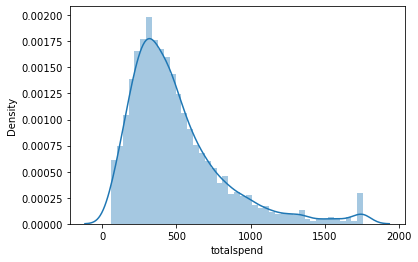

In [35]:
# For Linear regressin y(totalspend) should follow normal istribution
import seaborn as sns
sns.distplot(credit_cards.totalspend)

Now as you can see distribution is right skewed so we need to take log and then plot the graph.

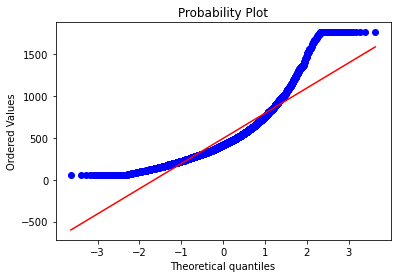

In [36]:
from scipy import stats
import pylab

stats.probplot(credit_cards.totalspend, dist="norm", plot=pylab )
pylab.show()


As we can see above graph our data is not distributed normally perfectly, so we will use boxcox techniue to make it perfect normal

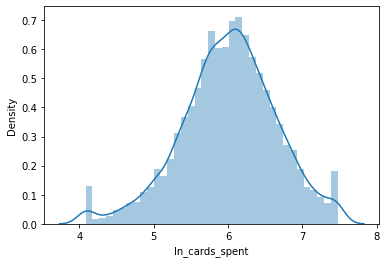

In [37]:
credit_cards['ln_cards_spent']=np.log(credit_cards['totalspend']+1)
sns.distplot(credit_cards.ln_cards_spent)
plt.show()

Now data is looking much better

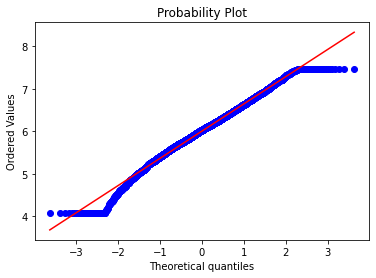

In [38]:
stats.probplot(credit_cards.ln_cards_spent, dist="norm", plot=pylab )
pylab.show()

Transformation is well and with comparision with erlier looks much better.

In [39]:
#Drop the y variables(totalspend) from dataframe because we are looking correlation between all x variables

credit_cards.drop(['totalspend'],axis=1,inplace=True)

In [41]:
# correlation matrix
corrm = credit_cards.corr()
corrm

,region,townsize,age,agecat,ed,edcat,employ,empcat,income,lninc,inccat,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,jobsat,spoused,spousedcat,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,address,addresscat,cars,carvalue,commute,commutetime,commutecar,commutemotorcycle,commutecarpool,commutebus,commuterail,commutepublic,commutebike,commutewalk,commutenonmotor,telecommute,polparty,polcontrib,vote,cardtenure,card2tenure,active,tenure,churn,longmon,lnlongmon,longten,lnlongten,tollfree,tollmon,lntollmon,tollten,equip,equipmon,equipten,callcard,cardmon,cardten,wireless,wiremon,wireten,multline,voice,pager,callid,callwait,forward,confer,ebill,owntv,hourstv,ownvcr,owndvd,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,gender_1,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,union_1,retire_1,default_1,marital_1,homeown_1,hometype_2,hometype_3,hometype_4,carown_0,carown_1,cartype_0,cartype_1,carcatvalue_1,carcatvalue_2,carcatvalue_3,carbought_0,carbought_1,carbuy_1,commutecat_2,commutecat_3,commutecat_4,commutecat_5,reason_2,reason_3,reason_4,reason_9,polview_2,polview_3,polview_4,polview_5,polview_6,polview_7,card_2,card_3,card_4,card_5,cardtype_2,cardtype_3,cardtype_4,cardbenefit_2,cardbenefit_3,cardbenefit_4,cardfee_1,cardtenurecat_2,cardtenurecat_3,cardtenurecat_4,cardtenurecat_5,card2_2,card2_3,card2_4,card2_5,card2type_2,card2type_3,card2type_4,card2benefit_2,card2benefit_3,card2benefit_4,card2fee_1,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,bfast_2,bfast_3,internet_1,internet_2,internet_3,internet_4,ln_cards_spent
region,1.000000,0.414030,-0.026525,-0.018455,0.013850,0.015710,-0.010204,-0.009345,0.036594,0.041040,0.041850,-0.006781,0.007582,0.005169,0.032081,0.029497,0.015631,0.052967,0.050299,0.045743,-0.012442,-0.021116,0.020746,0.001599,-0.008931,0.023959,0.022004,-0.021205,-0.004960,-0.000842,0.016280,0.040197,0.057388,0.188741,-0.011979,0.011722,-0.017045,0.051611,0.055818,0.062416,0.101007,0.099317,0.126942,-0.023519,-0.010911,0.008363,-0.011157,-0.000604,0.002166,0.002182,0.005033,-0.002515,0.010870,0.018975,0.005927,0.013277,0.013429,0.011870,0.007160,0.006683,0.023631,0.028996,0.017118,0.024336,0.021298,0.023889,0.031453,0.031773,0.023374,0.021835,0.022923,0.018778,0.023290,0.019332,0.026085,0.028630,0.009908,0.032778,0.006338,0.022061,0.011319,0.048589,0.040228,0.020596,0.007504,0.026391,0.036622,0.012312,-0.013004,0.005899,0.005694,-0.012810,0.006803,0.017984,-0.011378,0.001652,-0.010603,-0.013768,-0.042849,-0.006856,0.056498,0.045620,-0.022873,0.028886,0.005764,-0.016171,0.019204,-0.001469,0.006485,-0.028824,0.012041,0.031213,-0.002013,0.007464,-0.009821,-0.039056,-0.001195,0.095256,-0.033665,0.000854,-0.012033,-0.018787,-0.002395,-0.031468,0.006686,0.020568,0.014968,-0.019607,-0.012033,-0.010973,-0.011753,0.024155,-0.017251,0.007902,0.007537,0.002669,0.004662,0.025576,-0.031109,-0.028101,-0.006446,0.004205,0.004488,0.000200,-0.011166,0.003793,0.005834,-0.001378,0.014116,0.003969,-0.013359,-0.024497,0.010364,0.008733,0.003134,0.002296,-0.002638,0.001934,0.001824,-0.025937,0.022485,-0.011312,0.017262,0.011343,0.008395,0.039253
townsize,0.414030,1.000000,-0.075454,-0.069069,0.002901,0.003684,-0.059279,-0.058155,-0.009513,0.000895,-0.007590,-0.019571,-0.039217,-0.031156,-0.014550,-0.003003,-0.031187,0.026035,0.023247,0.044416,-0.001123,-0.018790,0.031583,-0.012798,0.009846,0.001667,0.020940,-0.007077,-0.042024,-0.043298,0.003619,0.001964,0.135606,0.487009,-0.031945,-0.004888,-0.016716,0.131766,0.116960,0.100376,0.186823,0.260841,0.297547,-0.021559,-0.015004,-0.016540,-0.005435,-0.042067,-0.040056,0.022788,-0.029870,0.000838,-0.017098,-0.015679,-0.021800,-0.020274,0.000660,-0.016274,-0.034717,-0.020592,-0.006343,0.001669,-0.007738,-0.024723,-0.015124,-0.017010,0.007908,0.005283,-0.006873,0.004592,-0.006880,-0.004057,-0.004099,-0.010574,0.002855,0.003592,-0.008312,0.026502,-0.002381,-0.004527,0.016431,0.020692,0.02

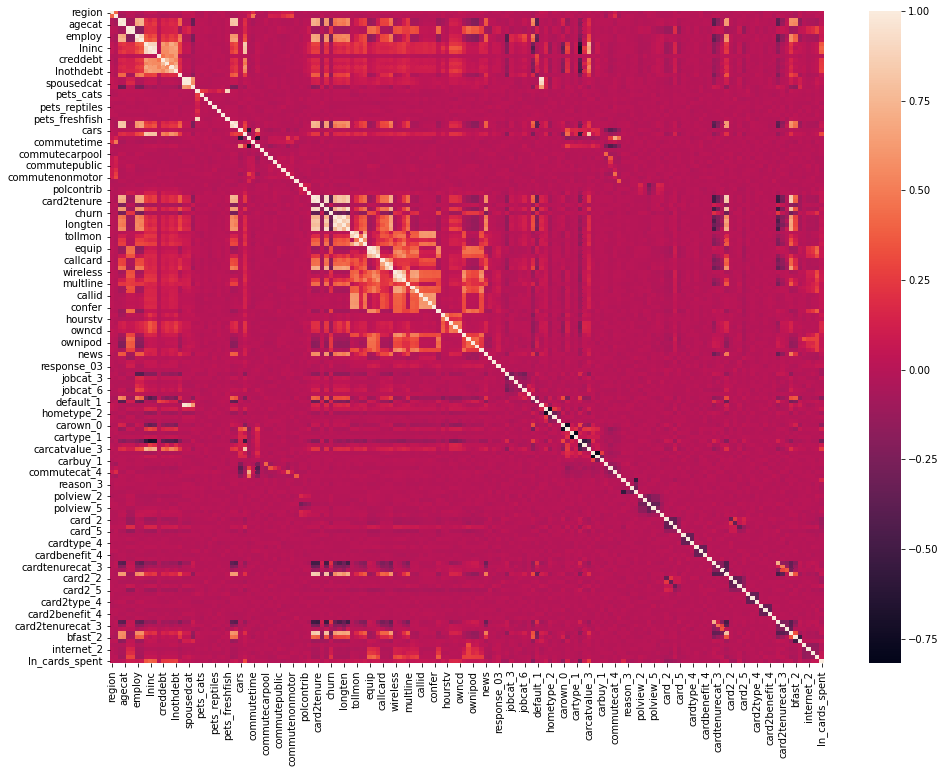

In [32]:
#heatmap showing correlation
plt.figure(figsize = (16, 12))
sns.heatmap(credit_cards.corr())

# Data Splitting
Spliting data into training and testing set

In [33]:
#Splitting the data in all x variable and y variable.

y = credit_cards.iloc[:,-1] #DEPENDENT variable
x = credit_cards.iloc[:,0:-1] #INDEPENDENT variable

# Feature Selection
# Check 1
selecting features through Random Forest *Regressor*

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [35]:
reg = RandomForestRegressor()
parameter = {'n_estimators':[20,30,40,50,80,90,100,120]}
cv = KFold(n_splits = 5,shuffle=True,random_state=10)
grid_search = GridSearchCV(reg,parameter,cv=cv,scoring='r2')
regression = grid_search.fit(x,y)

In [36]:
print(regression.best_params_)

{'n_estimators': 120}


In [37]:
reg = RandomForestRegressor(n_estimators=100)
reg.fit(x,y)

RandomForestRegressor()

By taking parameter 100 we build model and select our important features

In [38]:
indices = np.argsort(reg.feature_importances_)[::-1]
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
for f in range(x.shape[1]):
  feature_rank.loc[f] = [f+1,
                         x.columns[indices[f]],
                         reg.feature_importances_[indices[f]]]

feature_rank

,rank,feature,importance
0,1,income,0.098342
1,2,lninc,0.089349
2,3,card_3,0.026663
3,4,carvalue,0.025507
4,5,card_2,0.023417
...,...,...,...
160,161,cardtenurecat_5,0.000458
161,162,wireless,0.000451
162,163,card2tenurecat_5,0.000344
163,164,carcatvalue_3,0.000182


As we see above 165 features are arranged rank wise. We can select important feature accirding to rank.

In [39]:
#Select top 75 features and rest feature will dropped and then convert it into list
x_fea=feature_rank.loc[0:75,['feature']]
x_fea=x_fea['feature'].tolist()
print(x_fea)

['income', 'lninc', 'card_3', 'carvalue', 'card_2', 'commutetime', 'hourstv', 'debtinc', 'card_4', 'cardmon', 'reason_2', 'lncreddebt', 'creddebt', 'age', 'address', 'employ', 'ed', 'othdebt', 'lnothdebt', 'cardten', 'pets', 'lntollmon', 'tenure', 'longmon', 'cardtenure', 'lnlongmon', 'cars', 'region', 'tollten', 'card_5', 'townsize', 'lnlongten', 'spoused', 'card2_3', 'card2tenure', 'longten', 'card2_2', 'jobsat', 'equipten', 'commute', 'equipmon', 'tollmon', 'pets_dogs', 'reside', 'pets_freshfish', 'pets_cats', 'wiremon', 'gender_1', 'wireten', 'edcat', 'carbuy_1', 'card2_4', 'polparty', 'pets_birds', 'cardtype_2', 'commutebus', 'spousedcat', 'cardtype_3', 'bfast_3', 'reason_9', 'homeown_1', 'card2benefit_2', 'vote', 'card2type_2', 'inccat', 'hometype_2', 'polview_4', 'card2type_4', 'union_1', 'cartype_0', 'active', 'card2fee_1', 'cardbenefit_3', 'card2benefit_3', 'polview_2', 'pets_small']


In [40]:
# Create data frame with selected features
new_feature = ['income', 'lninc', 'card_3', 'carvalue', 'card_2', 'commutetime', 'hourstv', 'debtinc', 'card_4', 'cardmon', 'lncreddebt', 'age', 'creddebt', 'reason_2', 'address', 'employ', 'ed', 'othdebt', 'cardten', 'lnothdebt', 'pets', 'lntollmon', 'tenure', 'longmon', 'lnlongmon', 'cardtenure', 'region', 'card2tenure', 'card_5', 'lnlongten', 'spoused', 'cars', 'tollten', 'townsize', 'jobsat', 'card2_3', 'equipten', 'longten', 'card2_2', 'tollmon', 'equipmon', 'commute', 'pets_dogs', 'reside', 'pets_cats', 'inccat', 'pets_freshfish', 'gender_1', 'wiremon', 'wireten', 'card2_4', 'carbuy_1', 'card2type_2', 'edcat', 'vote', 'spousedcat', 'reason_9', 'card2benefit_2', 'cartype_0', 'cardtype_3', 'card2type_4', 'hometype_2', 'cardbenefit_4', 'commutebus', 'active', 'card2benefit_3', 'commutewalk', 'pets_birds', 'cardtype_2', 'polparty', 'jobcat_2', 'homeown_1', 'internet_1', 'carbought_0', 'polview_4', 'card2type_3']


In [41]:
df_new_fea= x[new_feature]

df_new_fea.head(5)

,income,lninc,card_3,carvalue,card_2,commutetime,hourstv,debtinc,card_4,cardmon,...,commutewalk,pets_birds,cardtype_2,polparty,jobcat_2,homeown_1,internet_1,carbought_0,polview_4,card2type_3
0,31.0,3.433987,1,14.3,0,22.0,13.0,11.1,0,14.25,...,1,0.0,0,1,0,0,0,1,0,1
1,15.0,2.708050,0,6.8,1,29.0,18.0,18.6,0,16.00,...,0,0.0,0,1,1,1,0,1,1,0
2,35.0,3.555348,0,18.8,1,24.0,21.0,9.9,0,23.00,...,0,0.0,0,1,1,1,0,1,0,0
3,20.0,2.995732,0,8.7,1,38.0,26.0,5.7,0,21.00,...,0,0.0,0,0,1,1,0,1,0,0
4,23.0,3.135494,0,10.6,0,32.0,27.0,1.7,1,17.25,...,1,0.0,1,0,1,0,0,1,1,1


New data frame created with above selected features

# Check - 2: Find multicolinearlity

In [42]:
# Check variation inflation factor
import statsmodels as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_new_fea.values, i) for i in range(df_new_fea.shape[1])]
vif["features"] = df_new_fea.columns
vif.sort_values(by=['VIF Factor'],ascending=False)

,VIF Factor,features
23,345.721688,longmon
24,314.325045,lnlongmon
1,297.083364,lninc
16,296.910021,ed
29,255.975801,lnlongten
...,...,...
57,1.494835,card2benefit_2
67,1.449103,pets_birds
62,1.349390,cardbenefit_4
28,1.344464,card_5


In [43]:
#Select only those features whose Vif is greater than 10.
vif1=vif[vif['VIF Factor']>10].reset_index().loc[:,['features']]
vif1.drop([0],axis=0,inplace=True)
drop_vars= vif1["features"].tolist()
drop_vars

['lninc',
 'commutetime',
 'hourstv',
 'debtinc',
 'cardmon',
 'age',
 'address',
 'ed',
 'cardten',
 'pets',
 'lntollmon',
 'tenure',
 'longmon',
 'lnlongmon',
 'cardtenure',
 'card2tenure',
 'lnlongten',
 'spoused',
 'tollten',
 'longten',
 'tollmon',
 'equipmon',
 'inccat',
 'pets_freshfish',
 'wiremon',
 'wireten',
 'edcat',
 'spousedcat']

In [44]:
df_new_fea.drop(columns=drop_vars,inplace=True,axis=1)

In [45]:
df_new_fea.head()

,income,card_3,carvalue,card_2,card_4,lncreddebt,creddebt,reason_2,employ,othdebt,...,commutewalk,pets_birds,cardtype_2,polparty,jobcat_2,homeown_1,internet_1,carbought_0,polview_4,card2type_3
0,31.0,1,14.3,0,0,0.183079,1.200909,0,0.0,2.240091,...,1,0.0,0,1,0,0,0,1,0,1
1,15.0,0,6.8,1,0,0.200505,1.222020,0,0.0,1.567980,...,0,0.0,0,1,1,1,0,1,1,0
2,35.0,0,18.8,1,0,-0.074056,0.928620,1,16.0,2.536380,...,0,0.0,0,1,1,1,0,1,0,0
3,20.0,0,8.7,1,0,-3.401690,0.033160,0,0.0,1.117200,...,0,0.0,0,0,1,1,0,1,0,0
4,23.0,0,10.6,0,1,-1.538705,0.214659,0,1.0,0.176341,...,1,0.0,1,0,1,0,0,1,1,1


28 Variables dropped due to high inflation factor

# Check 3
selecting features on the baisic of p values.
We reject features whose p values will greater tha 5%

In [46]:
#Build Regression model using statsmodels.api
import statsmodels.api as sm
x_ols = sm.add_constant(df_new_fea)
lm=sm.OLS(y,x_ols).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ln_cards_spent   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     46.98
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        21:47:17   Log-Likelihood:                -3945.9
No. Observations:                5000   AIC:                             7990.
Df Residuals:                    4951   BIC:                             8309.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.4160      0.061    105.389      0.000       6.297       6.535
income             0.0042      0.000     11.230      0.000       0.003       0.005
card_3            -0.5922      0.025    -24.011      0.000      -0.641      -0.544
carvalue           0.0008      0.001      1.042      0.298      -0.001       0.002
card_2            -0.5732      0.024    -23.447      0.000      -0.621      -0.525
card_4            -0.6507      0.025    -26.031      0.000      -0.700      -0.602
lncreddebt         0.0354      0.012      3.061      0.002       0.013       0.058
creddebt          -0.0096      0.006     -1.599      0.110      -0.021       0.002
reason_2           0.3709      0.037     10.101      0.000       0.299       0.443
employ            -0.0031      0.001     -3.001      0.003      -0.005      -0.001
othdebt           -0.0106      0.004     -2.876      0.004      -0.018      -0.003
lnothdebt          0.0604      0.014      4.343      0.000       0.033       0.088
region             0.0111      0.006      1.894      0.058      -0.000       0.023
card_5            -0.4508      0.041    -10.968      0.000      -0.531      -0.370
cars               0.0008      0.008      0.110      0.912      -0.014       0.016
townsize           0.0003      0.006      0.052      0.959      -0.012       0.012
jobsat            -0.0016      0.006     -0.260      0.795      -0.014       0.011
card2_3           -0.3064      0.022    -13.666      0.000      -0.350      -0.262
equipten        1.109e-05   8.76e-06      1.266      0.205   -6.08e-06    2.83e-05
card2_2           -0.3091      0.023    -13.652      0.000      -0.354      -0.265
commute           -0.0002      0.004     -0.048      0.961      -0.007       0.007
pets_dogs         -0.0001      0.010     -0.011      0.991      -0.020       0.020
reside             0.0074      0.006      1.268      0.205      -0.004       0.019
pets_cats         -0.0003      0.009     -0.030      0.976      -0.018       0.018
gender_1          -0.0581      0.015     -3.800      0.000      -0.088      -0.028
card2_4           -0.3355      0.024    -13.713      0.000      -0.383      -0.288
carbuy_1           0.0235      0.016      1.434      0.152      -0.009       0.056
card2type_2       -0.0132      0.022     -0.604      0.546      -0.056       0.030
vote               0.0100      0.016      0.640      0.522      -0.021       0.040
reason_9           0.1168      0.023      4.998      0.000       0.071       0.163
card2benefit_2     0.0054      0.019      0.286      0.775      -0.031       0.042
cartype_0         -0.0159      0.016     -1.011      0.312      -0.047       0.015
cardtype_3        -0.0007      0.019     -0.036      0.971      -0.037       0.036
card2type_4       -0.0070      0.021     -0.325      0.745      -0.049       0.035
hometype_2  

In [47]:
pval = lm.pvalues.sort_values(ascending=False)
d_col = pval[pval>0.05].reset_index()
d1_col = d_col['index'].to_list()

In [48]:
df_new_fea.drop(d1_col,axis=1,inplace=True)

32 more columns dropped because of pvalue > 5%

In [49]:
df_new_fea.head()

,income,card_3,card_2,card_4,lncreddebt,reason_2,employ,othdebt,lnothdebt,card_5,card2_3,card2_2,gender_1,card2_4,reason_9,card2benefit_3
0,31.0,1,0,0,0.183079,0,0.0,2.240091,0.806516,0,0,0,1,0,1,0
1,15.0,0,1,0,0.200505,0,0.0,1.567980,0.449788,0,0,0,0,1,1,1
2,35.0,0,1,0,-0.074056,1,16.0,2.536380,0.930738,0,0,0,1,1,0,1
3,20.0,0,1,0,-3.401690,0,0.0,1.117200,0.110826,0,1,0,0,0,1,0
4,23.0,0,0,1,-1.538705,0,1.0,0.176341,-1.735336,0,0,0,0,0,1,0


# All x variables should have a linear relationship with Y

Text(21.581250000000004, 0.5, 'Total_Spent')

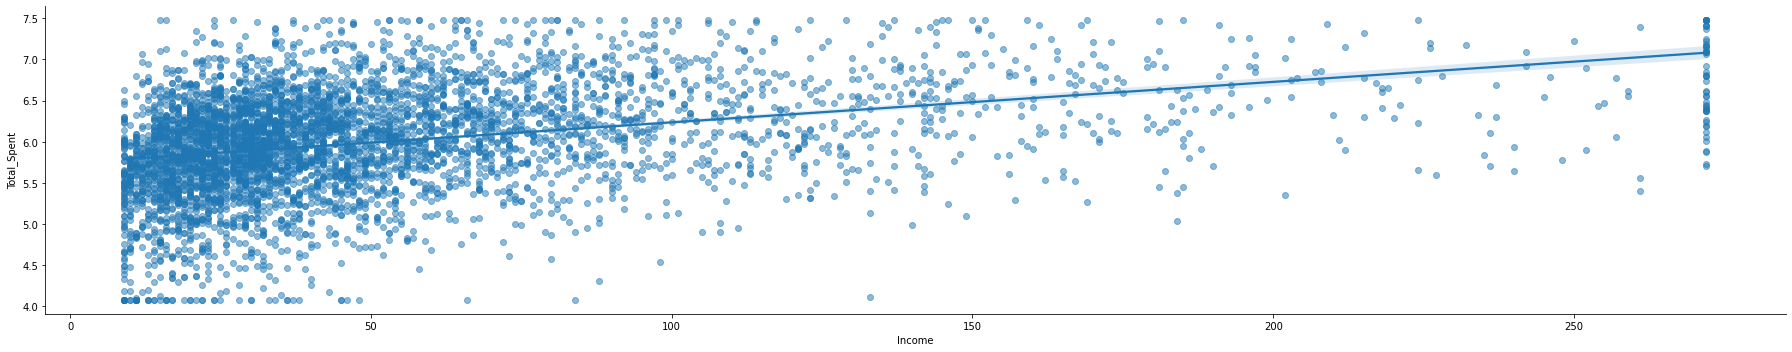

In [50]:
sns.lmplot(x="income",y="ln_cards_spent",data=credit_cards,aspect=5,scatter_kws={'alpha':0.5})
plt.xlabel("Income")
plt.ylabel("Total_Spent")


Text(21.581250000000004, 0.5, 'Total_Spent')

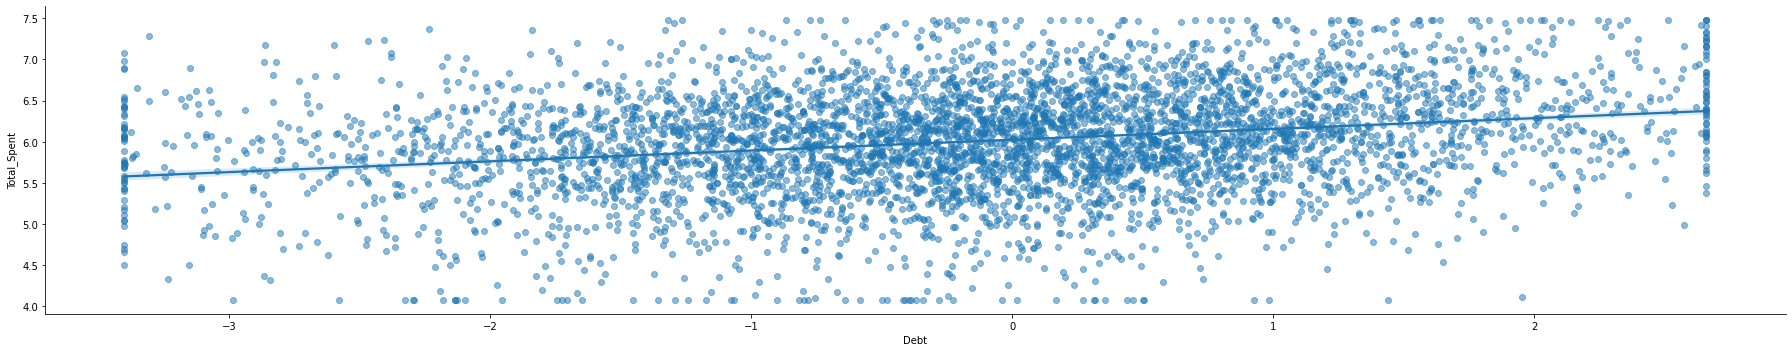

In [75]:
sns.lmplot(x="lncreddebt",y="ln_cards_spent",data=credit_cards,aspect=5,scatter_kws={'alpha':0.5})
plt.xlabel("Debt")
plt.ylabel("Total_Spent")


Text(21.581250000000004, 0.5, 'Total_Spent')

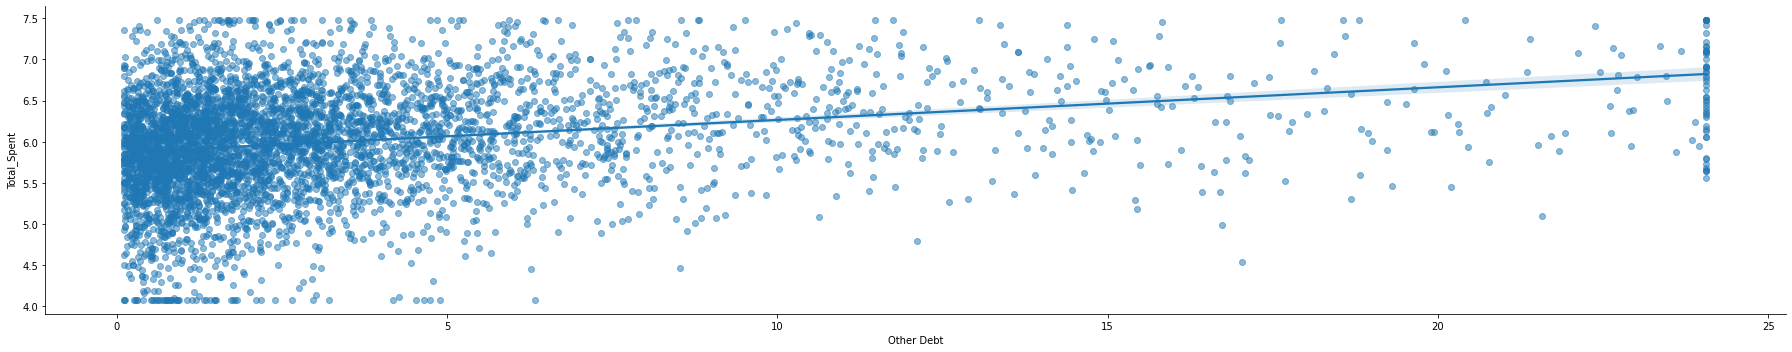

In [76]:
sns.lmplot(x="othdebt",y="ln_cards_spent",data=credit_cards,aspect=5,scatter_kws={'alpha':0.5})
plt.xlabel("Other Debt")
plt.ylabel("Total_Spent")


# Splitting Data
Splitting data in training and testing phase so that we can check model prediction power by giving new data after training data

In [51]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(df_new_fea,y,test_size=0.3,shuffle=True,random_state = 10)
print('No of obs in training: ', len(x_train), ' | ', 'No of obs in testing: ', len(x_test))

No of obs in training:  3500  |  No of obs in testing:  1500


data is splittedd with 70-30 ratio and 3500 data is in training set and 1500 in testing set

# Data Standarisation
We standarised the data to make them on single line

In [52]:
# importing standardscaler library
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
# New independent variable after scaling the data
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)




# Model creation

# 1) random Forest Regressor

In [53]:
# We again create Random forest classifier with new features and traing data set
reg = RandomForestRegressor()
parameter = {'n_estimators':[20,30,40,50,80,90,100,120],'criterion':['squared_error', 'absolute_error']}
cv = KFold(n_splits = 5,shuffle=True,random_state=10)
grid_search = GridSearchCV(reg,parameter,cv=cv,scoring='r2')
regression = grid_search.fit(x_train,y_train)

In [54]:
print(regression.best_score_)
print(regression.best_params_)

0.21307257291931075
{'criterion': 'absolute_error', 'n_estimators': 100}


In [55]:
reg_best = RandomForestRegressor(n_estimators=90,criterion='absolute_error').fit(x_train,y_train)

In [56]:
# y prediction on basis of test data
y_prec_train = reg_best.predict(x_train)
y_predicted = reg_best.predict(x_test)

In [57]:
#Calculating mean square error
from sklearn.metrics import mean_squared_error as mse
print("Train MSE:", mse(y_train, y_prec_train))
print("Test MSE:", mse(y_test, y_predicted))

Train MSE: 0.04693464953921992
Test MSE: 0.3052053895176624


In [58]:
# calculating r2 score for predicted value
from sklearn.metrics import r2_score
print("Train R2:", r2_score(y_train, y_prec_train))
print("Test R2:", r2_score(y_test, y_predicted))

# Calculating Absolute mean error
from sklearn.metrics import mean_absolute_error as mae
print("Train MAE:", mae(y_train, y_prec_train))
print("Test MAE:", mae(y_test, y_predicted))

Train R2: 0.8863501748898016
Test R2: 0.26130511876350626
Train MAE: 0.16847262140737368
Test MAE: 0.4351058024258759


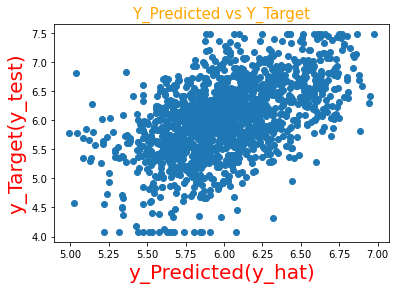

In [59]:
# The simplest way to compare the targets (y_train) and the predictions (y_predict) is to plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction
plt.scatter(y_predicted,y_test)
plt.xlabel('y_Predicted(y_hat)',size=20,c='red')
plt.ylabel('y_Target(y_test)',size=20,c='red')
plt.title('Y_Predicted vs Y_Target',size=15,c='orange')
plt.show()

[]

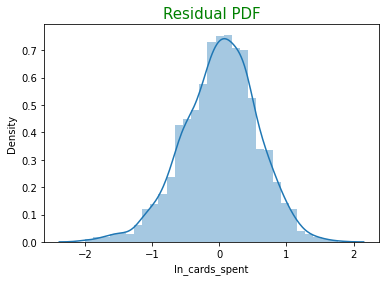

In [60]:
# Another useful check of our model is a residual plot
# We can plot the PDF of the residuals and check for anomalies
sns.distplot(y_test-y_predicted)
# Include a title
plt.title('Residual PDF',size=15, c='green')
plt.plot()
# In the best case scenario this plot should be normally distributed

# 2) SVM

In [61]:
# Our second model is support vector regressor
from sklearn.svm import SVR
reg2 = SVR()
reg2.fit(x_train,y_train)

SVR()

In [62]:
# y prediction on basis of test data
y_prec_train2 = reg2.predict(x_train)
y_predicted2 = reg2.predict(x_test)

In [63]:
#Calculating mean square error for test data
from sklearn.metrics import mean_squared_error as mse
print("Train MSE:", mse(y_train, y_prec_train2))
print("Test MSE:", mse(y_test, y_predicted2))

# calculating r2 score for predicted value
from sklearn.metrics import r2_score
print("Train R2:", r2_score(y_train, y_prec_train2))
print("Test R2:", r2_score(y_test, y_predicted2))

# Calculating Absolute mean error
from sklearn.metrics import mean_absolute_error as mae
print("Train MAE:", mae(y_train, y_prec_train2))
print("Test MAE:", mae(y_test, y_predicted2))

Train MSE: 0.24468283056191376
Test MSE: 0.29316102716057274
Train R2: 0.4075131875099546
Test R2: 0.2904563366859696
Train MAE: 0.3715762873829469
Test MAE: 0.4257468097153751


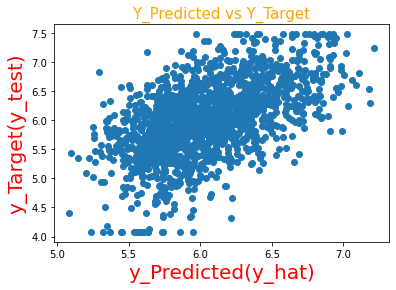

In [64]:
# The simplest way to compare the targets (y_train) and the predictions (y_predict) is to plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction
plt.scatter(y_predicted2,y_test)
plt.xlabel('y_Predicted(y_hat)',size=20,c='red')
plt.ylabel('y_Target(y_test)',size=20,c='red')
plt.title('Y_Predicted vs Y_Target',size=15,c='orange')
plt.show()

[]

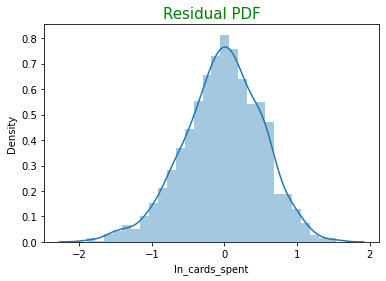

In [65]:
# Another useful check of our model is a residual plot
# We can plot the PDF of the residuals and check for anomalies
sns.distplot(y_test-y_predicted2)
# Include a title
plt.title('Residual PDF',size=15, c='green')
plt.plot()
# In the best case scenario this plot should be normally distributed

# 3) KNN

In [66]:
# Our third model k-neighbours
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
parameter = {'n_neighbors':np.arange(3,10)}
grid_search2 = GridSearchCV(knn,parameter,cv=cv,scoring='r2')
reg3 = grid_search2.fit(x_train,y_train)

In [67]:
print(reg3.best_score_)
print(reg3.best_params_)

0.18605174381345063
{'n_neighbors': 9}


In [68]:
knn = KNeighborsRegressor(n_neighbors=9).fit(x_train,y_train)

In [69]:
# y prediction on basis of test data
y_prec_train3 = knn.predict(x_train)
y_predicted3 = knn.predict(x_test)

In [70]:
#Calculating mean square error for test data
from sklearn.metrics import mean_squared_error as mse
print("Train MSE:", mse(y_train, y_prec_train3))
print("Test MSE:", mse(y_test, y_predicted3))

# calculating r2 score for predicted value
from sklearn.metrics import r2_score
print("Train R2:", r2_score(y_train, y_prec_train3))
print("Test R2:", r2_score(y_test, y_predicted3))

# Calculating Absolute mean error
from sklearn.metrics import mean_absolute_error as mae
print("Train MAE:", mae(y_train, y_prec_train3))
print("Test MAE:", mae(y_test, y_predicted3))

Train MSE: 0.2696267126483235
Test MSE: 0.3146209687239345
Train R2: 0.34711286782031925
Test R2: 0.23851639876566544
Train MAE: 0.4090938119232356
Test MAE: 0.44372797171388106


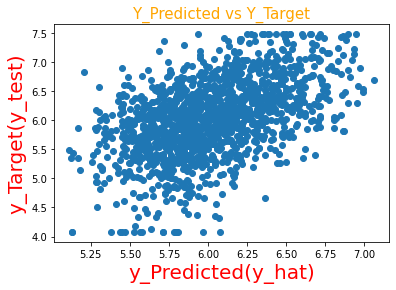

In [71]:
# The simplest way to compare the targets (y_train) and the predictions (y_predict) is to plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction
plt.scatter(y_predicted3,y_test)
plt.xlabel('y_Predicted(y_hat)',size=20,c='red')
plt.ylabel('y_Target(y_test)',size=20,c='red')
plt.title('Y_Predicted vs Y_Target',size=15,c='orange')
plt.show()

[]

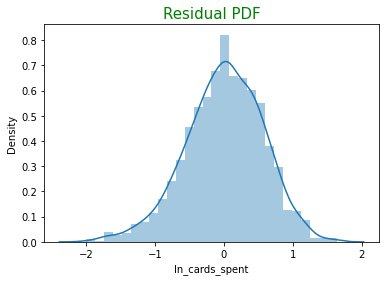

In [72]:
# Another useful check of our model is a residual plot
# We can plot the PDF of the residuals and check for anomalies
sns.distplot(y_test-y_predicted3)
# Include a title
plt.title('Residual PDF',size=15, c='green')
plt.plot()
# In the best case scenario this plot should be normally distributed

# Summary table

In [73]:
from prettytable import PrettyTable
pretty_table = PrettyTable()
pretty_table.field_names = ['Model', 'MSE', 'R2','MAE']
pretty_table.add_row(['Random Forest Regression(Train)',0.04,0.88,0.16 ])
pretty_table.add_row(['Random Forest(Test)', 0.30,0.26,0.43])
pretty_table.add_row(['\n', '\n', '\n','\n'])
pretty_table.add_row(['SVM(Train)',0.24,0.40,0.37])
pretty_table.add_row(['SVM(Test)',0.29,0.29,0.42])
pretty_table.add_row(['\n', '\n', '\n','\n'])
pretty_table.add_row(['KNN(Train)',0.26,0.34,0.40])
pretty_table.add_row(['KNN(Test)',0.31,0.23,0.44 ])
pretty_table.add_row(['\n', '\n', '\n','\n'])

print(pretty_table)

+---------------------------------+------+------+------+
|              Model              | MSE  |  R2  | MAE  |
+---------------------------------+------+------+------+
| Random Forest Regression(Train) | 0.04 | 0.88 | 0.16 |
|       Random Forest(Test)       | 0.3  | 0.26 | 0.43 |
|                                 |      |      |      |
|                                 |      |      |      |
|            SVM(Train)           | 0.24 | 0.4  | 0.37 |
|            SVM(Test)            | 0.29 | 0.29 | 0.42 |
|                                 |      |      |      |
|                                 |      |      |      |
|            KNN(Train)           | 0.26 | 0.34 | 0.4  |
|            KNN(Test)            | 0.31 | 0.23 | 0.44 |
|                                 |      |      |      |
|                                 |      |      |      |
+---------------------------------+------+------+------+
